In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, PredefinedSplit, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [105]:
train_data = pd.read_csv("../datasets/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [106]:
def split_data(data):
    X = data.drop("Survived", axis=1)
    y = data.loc[:,["Survived"]]

    return([X,y])

In [107]:
def test_model(preprocessing_pipeline, train_data, model,params):
    model_pipeline = Pipeline([("preprocessing",preprocessing_pipeline), ("model",model)])

    clf = GridSearchCV(model_pipeline,
            params,
            cv=10,
            scoring="accuracy",
            n_jobs=-1,
            verbose=1,
            refit=True)

    X,y = split_data(train_data)
    clf.fit(X, y.to_numpy().ravel())
    
    cv_results = pd.DataFrame(clf.cv_results_)
    cv_test_score = max(cv_results["mean_test_score"])
    print(cv_test_score*100)
    
    return(clf,cv_test_score*100)

In [108]:
def plot_scores(clf):
    res = pd.DataFrame(clf.cv_results_)
    res = res.loc[res["rank_test_score"]==1,:]

    score_cols = [x for x in res.columns if ("test_score" in x and "split" in x)]
    res = res.loc[:,score_cols]
    KNN_score = res.to_numpy().squeeze()

    plt.plot([1]*10, KNN_score, ".")
    plt.boxplot([KNN_score], vert=True, labels=['KNN'])
    plt.title('Boxplot of Array Values (Matplotlib)')
    plt.ylabel('Value')
    plt.grid(axis='y', linestyle='--', alpha=0.7) # Add a grid for better readability
    plt.show()

In [122]:
age_bucket_transformer = FunctionTransformer(lambda x : x//15)

In [123]:
cabin_transformer = FunctionTransformer(lambda x : x.isna())

In [151]:
sex_pipeline = make_pipeline(OrdinalEncoder(handle_unknown='error'))
#age_pipeline = make_pipeline(SimpleImputer(),StandardScaler())
age_pipeline = make_pipeline(KNNImputer(),age_bucket_transformer)
fare_pipeline = make_pipeline(SimpleImputer(),MinMaxScaler())
loc_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"),OneHotEncoder(handle_unknown="ignore"))
cabin_pipeline = make_pipeline(cabin_transformer)

preprocessing = ColumnTransformer(
                transformers = [
                    ("sex", sex_pipeline, ["Sex"]),
                    ("pass", "passthrough", ["Pclass"]),
                    ("age", age_pipeline, ["Age"]),
                    ("fare", fare_pipeline, ["Fare"]),
                    #("loc", loc_pipeline, ["Embarked"]),
                    #("cabin", cabin_pipeline, ["Cabin"])
                ],
                remainder = "drop"
)

In [159]:
#Decision Tree
param_grid = [{"model__max_depth":[3,5,7,9,11,13,15], 
               "model__min_samples_split":(8,10,12,14,16), 
               "model__max_features":(None,"sqrt","log2")}]

clf, acc = test_model(preprocessing, train_data, DecisionTreeClassifier(), param_grid)

Fitting 10 folds for each of 105 candidates, totalling 1050 fits
82.72284644194757


In [160]:
clf.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('sex',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder())]),
                                                  ['Sex']),
                                                 ('pass', 'passthrough',
                                                  ['Pclass']),
                                                 ('age',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(func=<function <lambda> at 0x15a0bc400>))]),
                                                  ['Age']),
                                                 ('fare',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['Fare'])])),
                ('model',
                 DecisionTreeClassifier(max_depth=13, min_samples_split=14))])

/var/folders/k5/qx7l6y390hd316r0yv70rlr00000gn/T/ipykernel_57976/652926003.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([KNN_score], vert=True, labels=['KNN'])


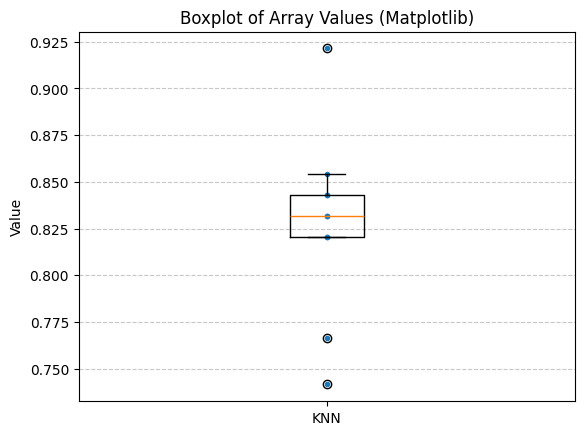

In [154]:
plot_scores(clf)

In [155]:
def model_predict(test_path,model):
    test_data = pd.read_csv(test_path)
    preds = model.predict(test_data)
    
    preds = pd.DataFrame([[x,y] for x,y in zip(test_data["PassengerId"],preds)], columns=["PassengerId","Survived"])
    
    return(preds)

In [156]:
knn_preds = model_predict("../datasets/test.csv",clf)
knn_preds.to_csv("../rf_test_pred.csv", index=False)